## Deep Transfer Learning using PINNs 
### Sam Arce     Nov 2021

## 1. Import Libraries
Using DeepXDE for PINN modeling, checking requirements: <br>
Tensorflow 2.x: Tensorflow >= 2.2.0 and TensorFlow Probability

In [1]:
import deepxde as dde
import numpy as np

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [8]:
import pandas as pd
data = pd.read_csv('train.dat', delim_whitespace=True)
data.head()

,#,x
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN


In [4]:
t = data['#']
y1 = data['x']
y2 = data['y']

KeyError: 'y'

In [66]:
t = np.array(t).reshape(39,-1)

In [69]:
y1 = np.array(y1).reshape(39,-1)

In [70]:
y2 = np.array(y2).reshape(39,-1)

In [72]:
ob_y1 = dde.PointSetBC(t, y1, component=0)
ob_y2 = dde.PointSetBC(t, y2, component=1)

In [86]:
ob_y2

Compiling model...
Building feed-forward neural network...
'build' took 0.073309 s

'compile' took 0.665346 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [4.61e-02, 3.27e-01, 0.00e+00, 1.00e+00, 5.63e-01, 6.66e-01]    [4.61e-02, 3.27e-01, 0.00e+00, 1.00e+00, 5.63e-01, 6.66e-01]    [1.00e+00]    
1000      [1.53e-02, 5.18e-03, 3.22e-07, 4.19e-06, 4.82e-03, 3.74e-03]    [1.53e-02, 5.18e-03, 3.22e-07, 4.19e-06, 4.82e-03, 3.74e-03]    [5.10e-01]    
2000      [2.80e-03, 3.09e-03, 1.75e-07, 3.13e-07, 1.86e-04, 2.78e-04]    [2.80e-03, 3.09e-03, 1.75e-07, 3.13e-07, 1.86e-04, 2.78e-04]    [5.10e-01]    
3000      [1.65e-03, 1.08e-03, 6.78e-09, 1.37e-08, 2.10e-05, 5.55e-05]    [1.65e-03, 1.08e-03, 6.78e-09, 1.37e-08, 2.10e-05, 5.55e-05]    [5.24e-01]    
4000      [1.16e-03, 5.11e-04, 1.56e-07, 3.44e-07, 1.27e-05, 2.09e-05]    [1.16

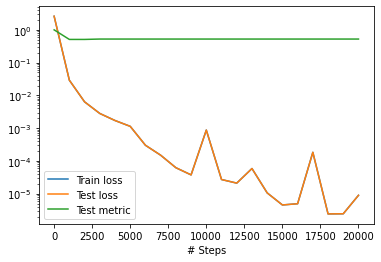

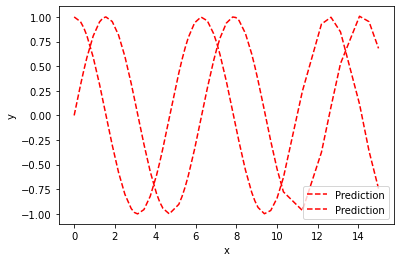

In [92]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


# def func(x):
#     """
#     y1 = sin(x)
#     y2 = cos(x)
#     """
#     return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 15)
ic1 = dde.IC(geom, np.sin, boundary, component=0)
ic2 = dde.IC(geom, np.cos, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2, ob_y1, ob_y2], 20, 2, anchors = t)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["accuracy"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)